In [1]:
# 連接google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 安裝pydicom讀取Dicom檔
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.2 MB/s eta 0:00:00


In [24]:
import pydicom
from tqdm import tqdm
import pandas as pd
from matplotlib import pyplot as plt
import os
import time
import numpy as np
import cv2
from PIL import Image, ImageOps

In [4]:
os.chdir('/content/drive/My Drive/陽明課程/1121/機器學習/Dataset/')

In [6]:
os.listdir()

['sample_submission.csv', 'train.csv', 'train', 'test']

In [5]:
# 觀察文件內容
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('sample_submission.csv')

In [ ]:
# 由第8行可以觀察到本資料集為multi-label classification
train_df.head(10)

## 提取DICOM影像，並觀察光度影響與分佈，可透過不同的像素轉換方式，在往後應用於改善模型表現

In [8]:
# 輸入：folder是要搜尋的資料夾路徑，list_of_tags是要提取的DICOM標籤清單

def dcmtag2table(folder, list_of_tags):
    list_of_tags = list_of_tags.copy()
    items = []
    table = []
    filelist = []
    print('Listing all files...')

    start = time.time()

    # 遊覽指定資料夾中的所有檔案（包括子資料夾），將所有檔案路徑儲存在filelist中
    for root, dirs, files in os.walk(folder, topdown=False):
        for name in files:
            filelist.append(os.path.join(root, name))

    # 使用pydicom.dcmread讀取DICOM檔案，提取指定的標籤資訊，並儲存於table中
    for _f in tqdm(filelist):
        # 如果遇到非DICOM檔案，程式會跳過並顯示相應的訊息，如Mac常會在資料夾中加入.DS_Store
        try:
            ds = pydicom.dcmread(_f, stop_before_pixels=True)
            items = []
            items.append(_f)

            for _tag in list_of_tags:
                if _tag in ds:
                    items.append(ds.data_element(_tag).value)
                else:
                    items.append('Not found')

            table.append((items))
        except:
            print('Skipping non-DICOM: ' + _f)

    # 將table清單轉置成矩陣，然後建立一個字典dictone，將DICOM標籤作為鍵，對應的資料作為值
    list_of_tags.insert(0, 'Filename')
    test = list(map(list, zip(*table)))
    dictone = {}

    for i, _tag in enumerate (list_of_tags):
        dictone[_tag] = test[i]

    # 轉換為DataFrame
    df = pd.DataFrame(dictone)

    return df

# 輸出：從指定資料夾中的DICOM檔案提取的DICOM標籤資訊的DataFrame

In [9]:
# 建立一個tags清單，其中包含要提取的DICOM標籤：1.影像的顏色解釋、2.分配的位元數，與、3.SOP（Service-Object Pair）實例的唯一識別碼
tags = ['PhotometricInterpretation', 'BitsAllocated', 'SOPInstanceUID' ]

# 使用dcmtag2table函式，將指定資料夾'/train', '/test'中的DICOM檔案與tags清單一起傳遞作為輸入參數，提取DICOM標籤並返回一個DataFrame
dicom_tags_train = dcmtag2table('/content/drive/My Drive/陽明課程/1121/機器學習/Dataset/train/', tags)
dicom_tags_test = dcmtag2table('/content/drive/My Drive/陽明課程/1121/機器學習/Dataset/test/', tags)

Listing all files...


100%|██████████| 1738/1738 [12:07<00:00,  2.39it/s]


Listing all files...


100%|██████████| 743/743 [05:12<00:00,  2.38it/s]


In [10]:
# 觀察提取DICOM標籤資訊的結果
dicom_tags_train.head(10)

,Filename,PhotometricInterpretation,BitsAllocated,SOPInstanceUID
0,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.11517871159945297695...
1,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.28370348751846810315...
2,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.61673588869632694474...
3,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.52961438508350278729...
4,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.88561832645976512814...
5,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.47385293940774274282...
6,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.27004276747767423234...
7,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.95024973449301076445...
8,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.11134132044055149977...
9,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.96145185219666838644...


MONOCHROME1    1659
MONOCHROME2      79
Name: PhotometricInterpretation, dtype: int64
The following images are with Photometric Interpretation MONOCHROME1


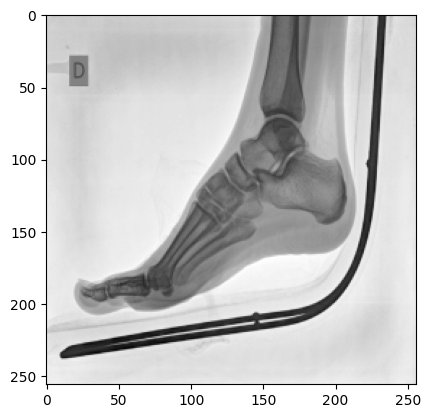

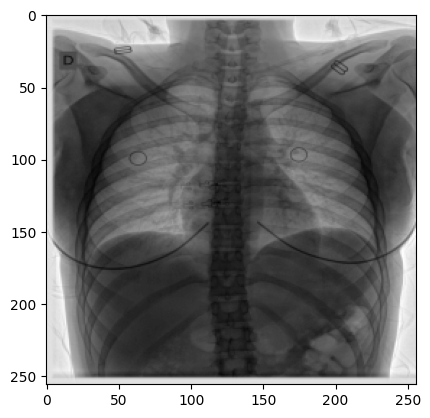

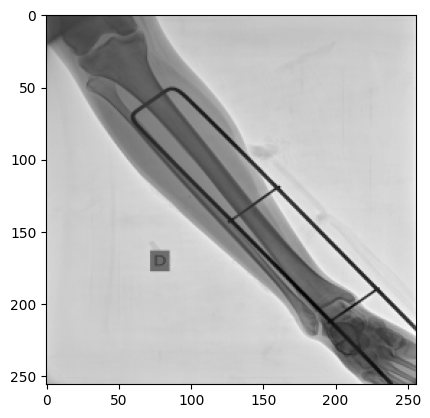

The following images are with Photometric Interpretation MONOCHROME2


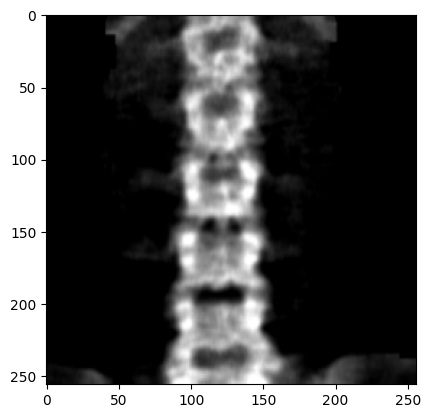

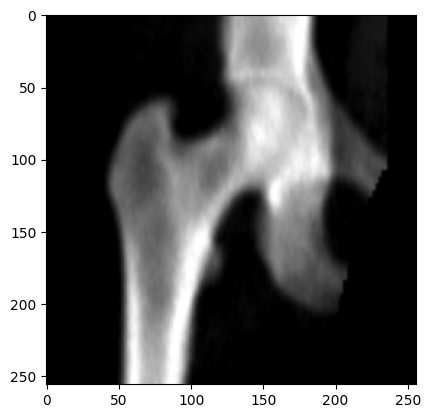

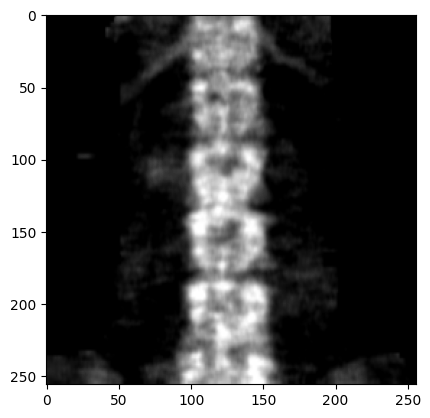

In [11]:
# 觀察不同影像光度，對影像的影響

# 列印'PhotometricInterpretation'欄位中不同值的出現次數，顯示'MONOCHROME1'(負片) 及'MONOCHROME2'(正片) 的出現次數
print(dicom_tags_train.PhotometricInterpretation.value_counts())

# 列印顯示前三張標籤為'MONOCHROME1'的影像
print('The following images are with Photometric Interpretation MONOCHROME1')
n = 0
for idx,row in dicom_tags_train[dicom_tags_train.PhotometricInterpretation == 'MONOCHROME1'].iterrows():
    dicom = pydicom.dcmread(row.Filename)
    img = dicom.pixel_array
    # 灰階影像
    plt.imshow(img, cmap='gray')
    plt.show()
    n += 1
    if n == 3:
        break

# 列印顯示前三張標籤為'MONOCHROME2'的影像
print('The following images are with Photometric Interpretation MONOCHROME2')
n = 0
for idx, row in dicom_tags_train[dicom_tags_train.PhotometricInterpretation == 'MONOCHROME2'].iterrows():
    dicom = pydicom.dcmread(row.Filename)
    img = dicom.pixel_array
    # 灰階影像
    plt.imshow(img, cmap='gray')
    plt.show()
    n += 1
    if n == 3:
        break

The following images are with Photometric Interpretation MONOCHROME1 but will be displayed as MONCHROME2


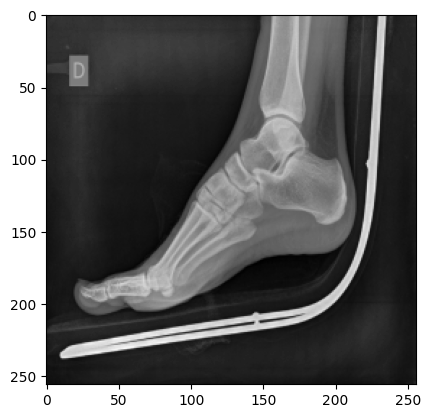

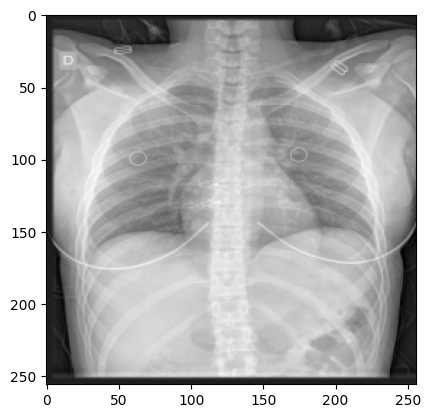

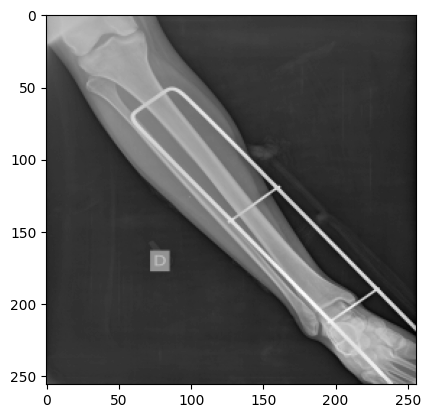

In [12]:
# 'MONOCHROME1'與'MONOCHROME2'可使用numpy convert()互相轉換

# 以不同的方式解釋像素值，使影像的顯示方式與原始的'MONOCHROME1'不同
print('The following images are with Photometric Interpretation MONOCHROME1 but will be displayed as MONCHROME2')
n = 0
# 篩選出標籤為'MONOCHROME1'的影像資訊，並使用迴圈遍歷這些'MONOCHROME1'的影像
for idx,row in dicom_tags_train[dicom_tags_train.PhotometricInterpretation == 'MONOCHROME1'].iterrows():
    dicom = pydicom.dcmread(row.Filename)
    # 從DICOM檔案中提取像素數組dicom.pixel_array。
    img = dicom.pixel_array
    # 使用np.invert(img)對像素值進行反轉，即將'MONOCHROME1'的像素值解釋方式轉換為'MONOCHROME2'的方式。
    plt.imshow(np.invert(img), cmap='gray')
    plt.show()
    n += 1
    if n == 3:
        break

## 製作每張影像對應的label，與實際用於訓練的資料集 (本資料集為multi-label classification)



In [13]:
os.chdir('/content/drive/My Drive/陽明課程/1121/機器學習/Dataset/train/')

In [14]:
train_df

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,0
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,15
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,12
3,1.2.826.0.1.3680043.8.498.10050991192143676483...,14
4,1.2.826.0.1.3680043.8.498.10053309524595490852...,3
...,...,...
1733,1.2.826.0.1.3680043.8.498.99711016467406172920...,14
1734,1.2.826.0.1.3680043.8.498.99727280485333900933...,11
1735,1.2.826.0.1.3680043.8.498.99935008698914755885...,3
1736,1.2.826.0.1.3680043.8.498.99969671777553755311...,2


In [15]:
# 將'train_df'與'test_df'，跟對應的DICOM標籤DF合併
train = dicom_tags_train.merge(train_df, on='SOPInstanceUID')
test = dicom_tags_test.merge(test_df, on='SOPInstanceUID')

In [16]:
# 建立22個label清單 (21 body parts + 1 others)
bodyparts = {
0 : 'Abdomen' ,
1 :'Ankle' ,
2 :'Cervical Spine',
3 : 'Chest' ,
4 :'Clavicles' ,
5 :'Elbow' ,
6 :'Feet' ,
7 : 'Finger' ,
8 : 'Forearm' ,
9 : 'Hand' ,
10 : 'Hip' ,
11 : 'Knee' ,
12 : 'Lower Leg' ,
13 : 'Lumbar Spine' ,
14 : 'Others' ,
15 :'Pelvis',
16 :'Shoulder' ,
17 :'Sinus' ,
18 : 'Skull' ,
19 : 'Thigh' ,
20 :'Thoracic Spine',
21: 'Wrist',
}

labels = ['Abdomen', 'Ankle', 'Cervical Spine',
       'Chest', 'Clavicles', 'Elbow', 'Feet', 'Finger', 'Forearm', 'Hand',
       'Hip', 'Knee', 'Lower Leg', 'Lumbar Spine', 'Others', 'Pelvis',
       'Shoulder', 'Sinus', 'Skull', 'Thigh', 'Thoracic Spine', 'Wrist']

In [17]:
# 將數字格式的標籤轉換為對應的字串標籤，並將其創建為新的欄位加入到訓練資料集中

# 首先將傳入的標籤（label）做了一些處理，包括去空格、轉換為整數，對應到'bodyparts'的字典中
def no_to_label(label):
    label_list_string = []
    trimed_label = label.rstrip()
    label_list = trimed_label.split(' ')
    label_list = [int(i) for i in label_list]

    for label in label_list:
        label_list_string.append(bodyparts[label])

    label_string = ' and '.join(label_list_string)
    return label_string

# 使用no_to_label函式處理train['Target']，並創建label columns
target_list = train['Target'].tolist()
label_column = []

for label in tqdm(target_list):
    label_string = no_to_label(label)
    label_column.append(label_string)

train['Label'] = label_column

# 列印出新欄位'Label'中唯一的字串標籤值
print(train['Label'].unique())
train.head(10)

100%|██████████| 1738/1738 [00:00<00:00, 419986.19it/s]

['Ankle and Feet' 'Chest' 'Lower Leg' 'Pelvis' 'Cervical Spine' 'Others'
 'Shoulder' 'Hip' 'Clavicles' 'Abdomen' 'Ankle' 'Skull' 'Thoracic Spine'
 'Hand and Wrist' 'Pelvis and Thigh' 'Ankle and Knee and Lower Leg'
 'Abdomen and Chest' 'Forearm' 'Feet' 'Finger and Hand' 'Knee' 'Sinus'
 'Lumbar Spine and Thoracic Spine' 'Elbow' 'Hip and Thigh' 'Lumbar Spine'
 'Wrist' 'Hand' 'Hip and Knee and Thigh'
 'Cervical Spine and Lumbar Spine and Thoracic Spine' 'Thigh'
 'Chest and Finger' 'Ankle and Lower Leg' 'Finger' 'Elbow and Forearm'
 'Forearm and Shoulder' 'Knee and Lower Leg'
 'Cervical Spine and Thoracic Spine' 'Abdomen and Pelvis' 'Chest and Feet'
 'Chest and Pelvis']


,Filename,PhotometricInterpretation,BitsAllocated,SOPInstanceUID,Target,Label
0,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.11517871159945297695...,1 6,Ankle and Feet
1,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.28370348751846810315...,3,Chest
2,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.61673588869632694474...,12,Lower Leg
3,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.52961438508350278729...,12,Lower Leg
4,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.88561832645976512814...,15,Pelvis
5,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.47385293940774274282...,2,Cervical Spine
6,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.27004276747767423234...,1 6,Ankle and Feet
7,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.95024973449301076445...,3,Chest
8,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.11134132044055149977...,3,Chest
9,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.96145185219666838644...,3,Chest


<Axes: xlabel='Label'>

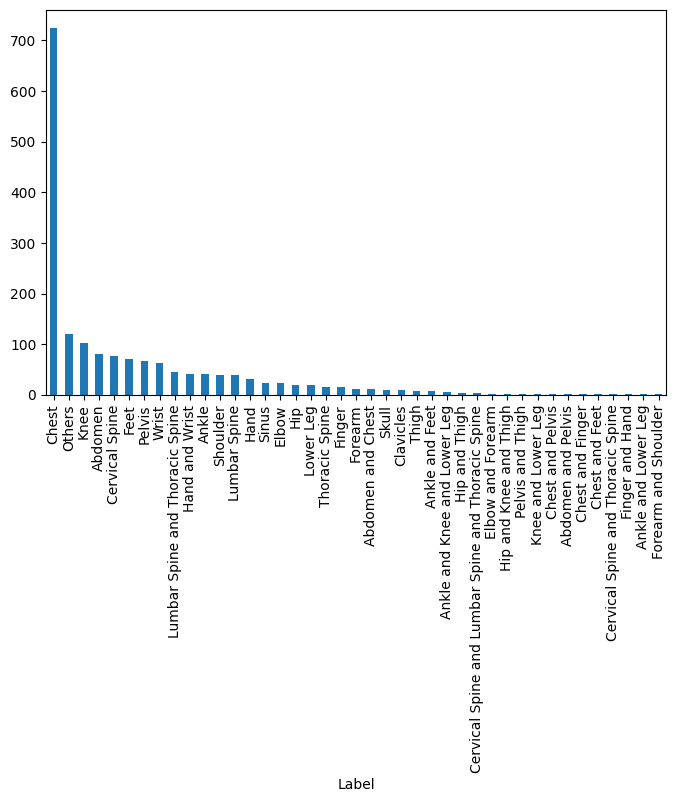

In [18]:
# 統計在所有影像中，每個標籤出現的次數
Grouped_target = train.groupby(by='Label').size().sort_values(ascending=False)

%matplotlib inline

plt.rcParams['figure.figsize'] = (8, 5)
Grouped_target.plot.bar()

In [19]:
# 了解不同標籤在整個訓練資料集中的分佈情況
label_nums = train.Label.value_counts()
label_nums

Chest                                                 724
Others                                                120
Knee                                                  102
Abdomen                                                80
Cervical Spine                                         77
Feet                                                   70
Pelvis                                                 67
Wrist                                                  63
Lumbar Spine and Thoracic Spine                        45
Hand and Wrist                                         42
Ankle                                                  41
Shoulder                                               40
Lumbar Spine                                           39
Hand                                                   31
Sinus                                                  23
Elbow                                                  23
Hip                                                    19
Lower Leg     

In [20]:
# 集中在出現頻率高的標籤上進行訓練或分析，忽略那些出現次數較少的標籤 (出現低於10次的)，以達到更好的資料平衡或更有效的訓練目的
# 建立遮罩來篩選訓練資料集，只保留標籤出現次數超過9次的資料
train = train[train.Label.isin(label_nums.index[label_nums.gt(9)])]

In [56]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras import regularizers
from keras import Sequential
from keras.layers import Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.utils import plot_model
from keras import backend as K
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [22]:
# 使用LabelEncoder()將每個label轉換為數字，以用於訓練 (請注意，本處由LabelEncoder()自動轉換，並非對應為資料集本身提供的每個body part的數字label)
to_numeric = LabelEncoder()
train['Label_to_numeric'] = to_numeric.fit_transform(train['Target'])
train.head(10)

,Filename,PhotometricInterpretation,BitsAllocated,SOPInstanceUID,Target,Label,Label_to_numeric
1,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.28370348751846810315...,3,Chest,16
2,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.61673588869632694474...,12,Lower Leg,5
3,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.52961438508350278729...,12,Lower Leg,5
4,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.88561832645976512814...,15,Pelvis,9
5,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.47385293940774274282...,2,Cervical Spine,13
7,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.95024973449301076445...,3,Chest,16
8,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.11134132044055149977...,3,Chest,16
9,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.96145185219666838644...,3,Chest,16
10,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.16189589602075090825...,3,Chest,16
11,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME2,8,1.2.826.0.1.3680043.8.498.75354982972213938063...,14,Others,8


In [31]:
!mkdir ./TrainingImages

## 因X-ray的DICOM影像通常為2-4000*2-4000，所以需將DICOM影像轉換為PNG格式，並儲存於指定資料夾


In [32]:
images_path = './TrainingImages'

ImagePath = []
file_name = train['Filename'].to_list()
sop = train['SOPInstanceUID'].to_list()

# 處理每個配對的檔案名稱和SOPInstanceUID
for file, sopId in tqdm(zip(file_name, sop)):
    ds = pydicom.dcmread(file)

    # 將DICOM影像的像素陣列進行標準化處理
    normalized = (ds.pixel_array - np.mean(ds.pixel_array)) / np.std(ds.pixel_array)
    # 將標準化後的像素值映射至0到1之間
    mat  = (normalized + 1) /2
    # 將數值轉換為影像格式，'L'表示灰度影像
    img = Image.fromarray(np.uint8(mat * 255), 'L')

    # PNG影像儲存路徑
    file_path = os.path.join(images_path,sopId+ '.png')
    img.save(file_path)
    ImagePath.append(file_path)

# 將ImagePath列表中的影像路徑加入到訓練資料集新創建的'Imagepath'欄位中，用於後續的資料操作或分析
train['Imagepath'] = ImagePath
train.head(10)

1688it [00:30, 54.91it/s]


,Filename,PhotometricInterpretation,BitsAllocated,SOPInstanceUID,Target,Label,Label_to_numeric,Imagepath
1,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.28370348751846810315...,3,Chest,16,./TrainingImages/1.2.826.0.1.3680043.8.498.283...
2,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.61673588869632694474...,12,Lower Leg,5,./TrainingImages/1.2.826.0.1.3680043.8.498.616...
3,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.52961438508350278729...,12,Lower Leg,5,./TrainingImages/1.2.826.0.1.3680043.8.498.529...
4,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.88561832645976512814...,15,Pelvis,9,./TrainingImages/1.2.826.0.1.3680043.8.498.885...
5,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.47385293940774274282...,2,Cervical Spine,13,./TrainingImages/1.2.826.0.1.3680043.8.498.473...
7,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.95024973449301076445...,3,Chest,16,./TrainingImages/1.2.826.0.1.3680043.8.498.950...
8,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.11134132044055149977...,3,Chest,16,./TrainingImages/1.2.826.0.1.3680043.8.498.111...
9,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.96145185219666838644...,3,Chest,16,./TrainingImages/1.2.826.0.1.3680043.8.498.961...
10,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.16189589602075090825...,3,Chest,16,./TrainingImages/1.2.826.0.1.3680043.8.498.161...
11,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME2,8,1.2.826.0.1.3680043.8.498.75354982972213938063...,14,Others,8,./TrainingImages/1.2.826.0.1.3680043.8.498.753...


## 準備訓練與驗證資料集，訓練集用於模型的訓練，驗證集則用於評估模型的效果和調整參數

In [33]:
# 將原始的訓練資料集按照90%和10%的比例分割成訓練集和驗證集
# 創建90%驗證集
train_data = train.sample(frac=0.9)

# 創建10%驗證集
val_data = train.loc[~train['Filename'].isin(train_data['Filename'])].copy()

## 透過data augmentation擴增訓練資料集的多樣性以提高模型的泛化能力

In [36]:
class DataAugmentation:
    # 設定三個參數，train、val、batch_size
    def __init__(self, train, val, batch_size):
        self.train = train
        self.val = val
        self.test = test
        self.batch_size = batch_size

    # 處理訓練資料集的data augmentation，包括亮度調整、水平與垂直位移、縮放與水平翻轉等
    def train_augment(self):
        train_datagen = ImageDataGenerator(
        brightness_range=[0.4, 1.5],
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

        # 資料生成並指定影像路徑(x_col)和標籤(y_col)欄位，以及目標尺寸和批次大小等參數
        train_generator_df = train_datagen.flow_from_dataframe(
            dataframe=self.train,
            directory=None,
            class_mode='raw',
            x_col='Imagepath',
            y_col='Label_to_numeric',
            target_size=(224, 224),
            batch_size=self.batch_size,
            rescale=1.0 / 255,
            seed=2020)

        return train_generator_df


    # 處理驗證資料集的data augmentation，此處只做影像的讀取和基本處理
    def valid_augment(self):
        val_datagen = ImageDataGenerator()

        # 資料生成並指定影像路徑(x_col)和標籤(y_col)欄位，以及目標尺寸和批次大小等參數
        val_generator_df = val_datagen.flow_from_dataframe(
            dataframe=self.val,
            directory=None,
            class_mode='raw',
            x_col='Imagepath',
            y_col='Label_to_numeric',
            target_size=(224, 224),
            batch_size=self.batch_size,
            rescale=1.0 / 255,
            seed=2021)

        return val_generator_df

In [37]:
# 實際生成data augmentation後的影像
# 創建實例
dat_aug = DataAugmentation(train_data, val_data, 64)

# 生成data augmentation後的訓練集
train_gen = dat_aug.train_augment()

# 生成data augmentation後的驗證集
val_gen = dat_aug.valid_augment()

Found 1519 validated image filenames.
Found 169 validated image filenames.


## ResNet50V2的transfer learning

In [38]:
from keras.applications.resnet_v2 import ResNet50V2

In [41]:
# 使用ResNet50V2模型作為特徵提取器，使用在ImageNet數據集上的權重，並指定輸入影像的尺寸和通道數為(256, 256, 3)，且設置trainable=False，代表模型的權重保持固定，不會在後續的訓練過程中更新
resNet50V2 = ResNet50V2(weights='imagenet', input_shape=(256, 256, 3), include_top=False)
resNet50V2.trainable = False

In [49]:
# 創建連接在ResNet50V2後的客製化模型，包括全連接層、池化層、Batch Normalization、Dropout等，以完成本案的訓練並優化
model = Sequential()
model.add(resNet50V2)
model.add(BatchNormalization(renorm=True))
model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(64, activation='relu'))
# 輸出層，使用softmax激活函數，用於將模型預測的概率分佈輸出為各個類別的概率，對應於訓練資料集中標籤的類別數量
model.add(Dense(len(train['Label_to_numeric'].unique()), activation='softmax'))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 batch_normalization_4 (Bat  (None, 8, 8, 2048)        14336     
 chNormalization)                                                
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_11 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 256)              

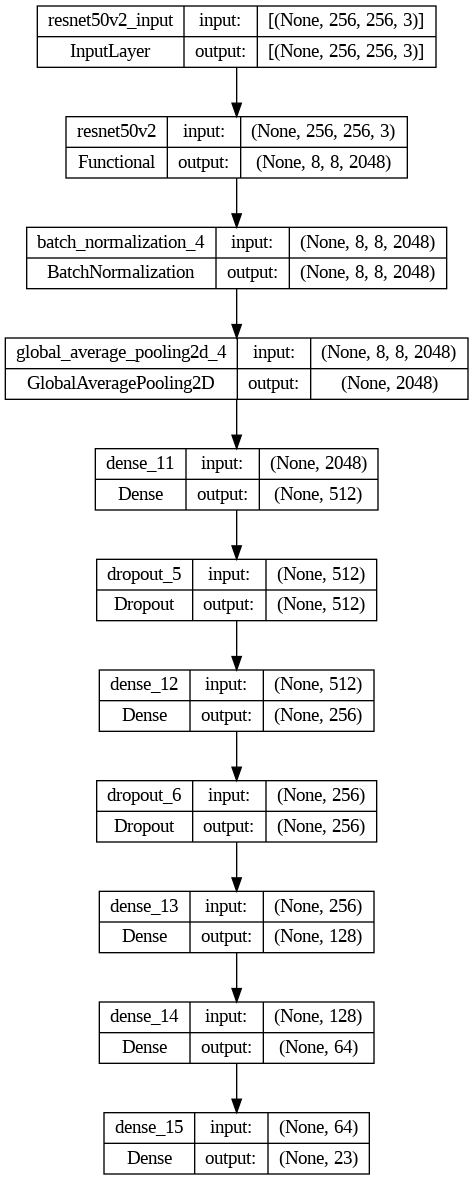

In [55]:
# 檢視模型的摘要信息，其中包括模型的架構和參數統計
# Layer (層): 列出了模型中每一層的名稱、類型和輸出形狀
# Output Shape (輸出形狀): 每個層的輸出形狀。這個形狀是指每個批次(batch)資料經過該層後的形狀
# Param # (參數數量): 每層的參數數量，這包括可訓練參數（weights）和不可訓練參數（如偏差項等）的總數量
# Trainable (可訓練) / Non-Trainable (不可訓練): 顯示哪些參數是可以被訓練的（需要在訓練過程中進行調整）和哪些是固定的（在訓練過程中保持不變）
model.summary()
plot_model(model, show_shapes=True)

## 使用accuracy與F1 score評估二元分類模型性能的指標，綜合考慮了模型的精確度和召回率

In [52]:
# K.round用於將張量中的值四捨五入到最接近的整數
# K.clip用於對張量進行截斷，K.sum用於計算張量的和，以及K.epsilon用於添加平滑項
def f1(y_true, y_pred):
    # 計算模型的召回率
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall

    # 計算模型的精確度
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    # K.epsilon() -> 是一個很小的數，用於避免分母為零的情況，通常稱為平滑項（smoothing term）
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [53]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.8 MB/s eta 0:00:00


In [54]:
import tensorflow_addons as tfa

# 模型被配置並準備進行訓練，使用了優化器'Adam'、損失函數'sparse_categorical_crossentropy'以及評估指標'accuracy'與'F1 score'
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', f1])

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [57]:
# 加入Early Stopping的回調函數，用於在訓練模型時可自動監控模型性能並根據特定條件來停止訓練過程，在沒有觀察到足夠改善時提前終止訓練，從而幫助防止over fitting並節省訓練時間
# 訓練過程中沒有改善容忍次數patience=20，改善的最小變化量min_delta=0.0001，當訓練停止時，將恢復在訓練過程中觀察到的最佳模型權重restore_best_weights=True
early = EarlyStopping(
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True)

In [58]:
# 開始訓練模型，參數包括train_gen、val_gen (資料增強後的資料)，epochs=100 (100次訓練)，callbacks (早期停止)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=[early])

Epoch 1/100
24/24 [==============================] - 54s 2s/step - loss: 24.2413 - accuracy: 0.2041 - f1: 7.4963 - val_loss: 10.3090 - val_accuracy: 0.4024 - val_f1: 21.7345
Epoch 2/100
24/24 [==============================] - 40s 2s/step - loss: 10.0973 - accuracy: 0.3015 - f1: 20.1690 - val_loss: 9.7790 - val_accuracy: 0.4024 - val_f1: 26.0521
Epoch 3/100
24/24 [==============================] - 35s 1s/step - loss: 9.4602 - accuracy: 0.3463 - f1: 23.9361 - val_loss: 9.2394 - val_accuracy: 0.4024 - val_f1: 26.9630
Epoch 4/100
24/24 [==============================] - 35s 1s/step - loss: 8.9645 - accuracy: 0.3627 - f1: 25.0590 - val_loss: 8.7197 - val_accuracy: 0.4024 - val_f1: 27.3927
Epoch 5/100
24/24 [==============================] - 35s 1s/step - loss: 8.4724 - accuracy: 0.4022 - f1: 24.4660 - val_loss: 8.2318 - val_accuracy: 0.4024 - val_f1: 26.1555
Epoch 6/100
24/24 [==============================] - 37s 2s/step - loss: 8.0293 - accuracy: 0.4174 - f1: 23.6662 - val_loss: 7.8034 -

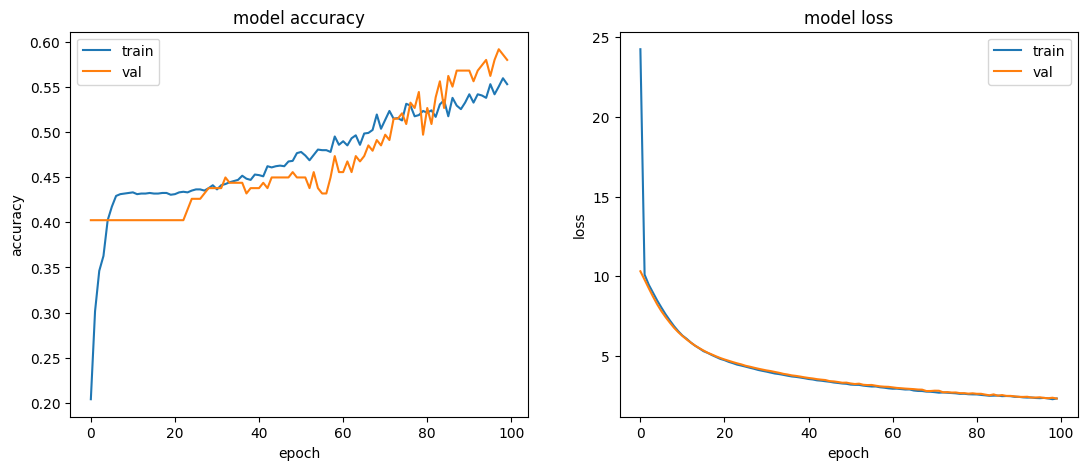

In [66]:
# 繪製模型訓練過程中訓練集和驗證集的準確度與損失變化曲線，觀察是否有過擬合
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper right')

fig.show()

## 驗證模型在測試集上的表現

In [67]:
!mkdir testDir
!mkdir testDir/Prediction

In [69]:
# 將測試集中的DICOM影像轉換為PNG格式，並保存到指定資料夾，作法與轉換訓練集的方式一樣

images_path = "./testDir/Prediction"

ImagePath = []
file_name = test['Filename'].to_list()
sop = test['SOPInstanceUID'].to_list()

for file,sopId in tqdm(zip(file_name,sop)):
    ds = pydicom.dcmread(file)
    normalized = (ds.pixel_array - np.mean(ds.pixel_array)) / np.std(ds.pixel_array)
    mat = (normalized + 1) / 2
    img = Image.fromarray(np.uint8(mat * 255), 'L')
    file_path = os.path.join(images_path,sopId + '.png')
    img.save(file_path)
    ImagePath.append(file_path)

test['Imagepath'] = ImagePath
test.head(10)

743it [00:14, 51.98it/s]


,Filename,PhotometricInterpretation,BitsAllocated,SOPInstanceUID,Target,Imagepath
0,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.48647330600134165982...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,./testDir/Prediction/1.2.826.0.1.3680043.8.498...
1,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.10594700500406668091...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,./testDir/Prediction/1.2.826.0.1.3680043.8.498...
2,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.13038526348243066795...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,./testDir/Prediction/1.2.826.0.1.3680043.8.498...
3,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.22291222279615112729...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,./testDir/Prediction/1.2.826.0.1.3680043.8.498...
4,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.11687379978340905164...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,./testDir/Prediction/1.2.826.0.1.3680043.8.498...
5,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.22177190624986661383...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,./testDir/Prediction/1.2.826.0.1.3680043.8.498...
6,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.82425260036002816026...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,./testDir/Prediction/1.2.826.0.1.3680043.8.498...
7,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.11702521518856958877...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,./testDir/Prediction/1.2.826.0.1.3680043.8.498...
8,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.67021259860462942935...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,./testDir/Prediction/1.2.826.0.1.3680043.8.498...
9,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.11398399630190221307...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,./testDir/Prediction/1.2.826.0.1.3680043.8.498...


In [70]:
# 檢查格式轉換是否確實存於./testDir/Prediction
dir_path = './testDir/Prediction'
os.listdir(dir_path)[:3]

['1.2.826.0.1.3680043.8.498.48647330600134165982918843706396853173.png',
 '1.2.826.0.1.3680043.8.498.10594700500406668091400744565817444299.png',
 '1.2.826.0.1.3680043.8.498.13038526348243066795431414647495267698.png']

In [73]:
# 將測試集中的標籤轉換為數字，作法與轉換訓練集的方式一樣
target_list = test['Target'].tolist()
label_column = []

for label in tqdm(target_list):
    label_string = no_to_label(label)
    label_column.append(label_string)

test['Label'] = label_column

test['Label'].unique()
test.head(10)

100%|██████████| 743/743 [00:00<00:00, 96288.21it/s]


,Filename,PhotometricInterpretation,BitsAllocated,SOPInstanceUID,Target,Imagepath,Label
0,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.48647330600134165982...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,./testDir/Prediction/1.2.826.0.1.3680043.8.498...,Abdomen and Ankle and Cervical Spine and Chest...
1,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.10594700500406668091...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,./testDir/Prediction/1.2.826.0.1.3680043.8.498...,Abdomen and Ankle and Cervical Spine and Chest...
2,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.13038526348243066795...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,./testDir/Prediction/1.2.826.0.1.3680043.8.498...,Abdomen and Ankle and Cervical Spine and Chest...
3,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.22291222279615112729...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,./testDir/Prediction/1.2.826.0.1.3680043.8.498...,Abdomen and Ankle and Cervical Spine and Chest...
4,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.11687379978340905164...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,./testDir/Prediction/1.2.826.0.1.3680043.8.498...,Abdomen and Ankle and Cervical Spine and Chest...
5,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.22177190624986661383...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,./testDir/Prediction/1.2.826.0.1.3680043.8.498...,Abdomen and Ankle and Cervical Spine and Chest...
6,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.82425260036002816026...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,./testDir/Prediction/1.2.826.0.1.3680043.8.498...,Abdomen and Ankle and Cervical Spine and Chest...
7,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.11702521518856958877...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,./testDir/Prediction/1.2.826.0.1.3680043.8.498...,Abdomen and Ankle and Cervical Spine and Chest...
8,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.67021259860462942935...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,./testDir/Prediction/1.2.826.0.1.3680043.8.498...,Abdomen and Ankle and Cervical Spine and Chest...
9,/content/drive/My Drive/陽明課程/1121/機器學習/Dataset...,MONOCHROME1,16,1.2.826.0.1.3680043.8.498.11398399630190221307...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,./testDir/Prediction/1.2.826.0.1.3680043.8.498...,Abdomen and Ankle and Cervical Spine and Chest...


In [75]:
# 使用 Keras 中的 ImageDataGenerator 和 flow_from_directory 方法來創建測試資料的資料生成器
# 可以方便地以批次的方式載入測試圖像資料，並進行後續的模型預測或評估
from pathlib import Path

test_path = Path('./testDir')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(256, 256),
    batch_size=32,
    # 指定資料集的類別模式為 None，表示不返回標籤資訊（因為這是測試資料）。
    class_mode=None,
    # 不對測試資料進行洗牌，保持其原始順序。
    shuffle=False)

Found 743 images belonging to 1 classes.


In [88]:
# 進行測試集的預測
prediction = model.predict(test_generator)
prediction.shape

24/24 [==============================] - 3s 136ms/step


(743, 23)

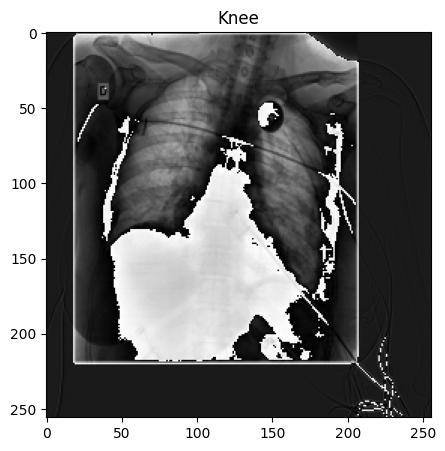

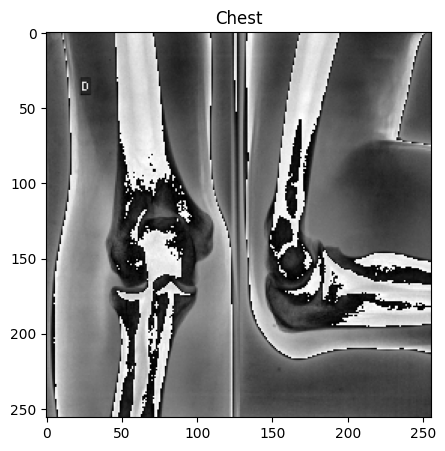

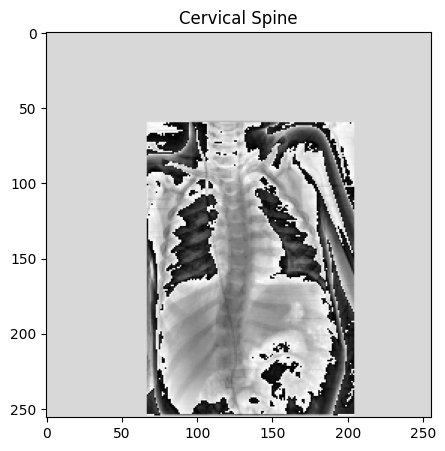

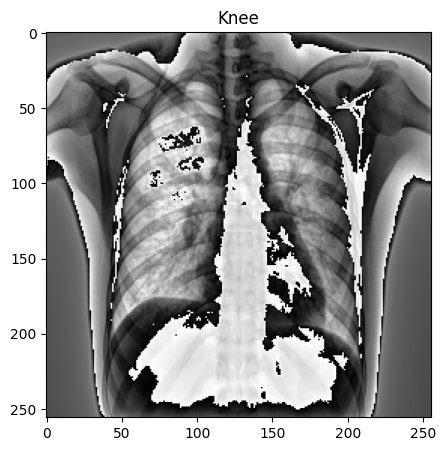

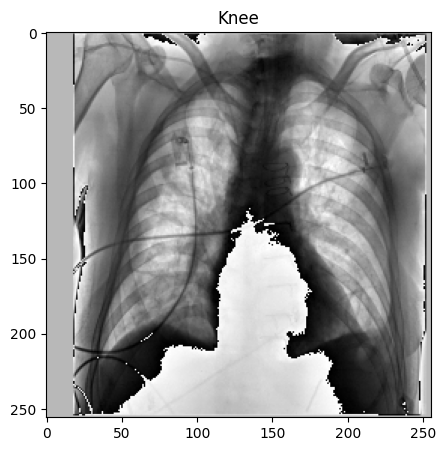

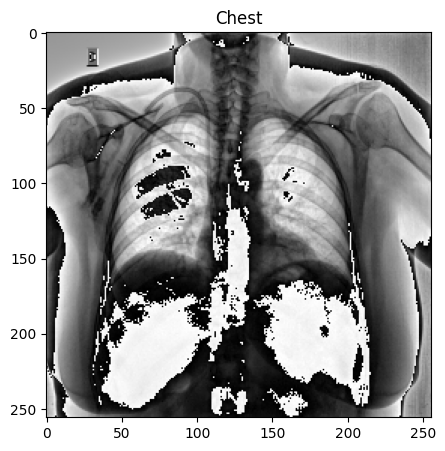

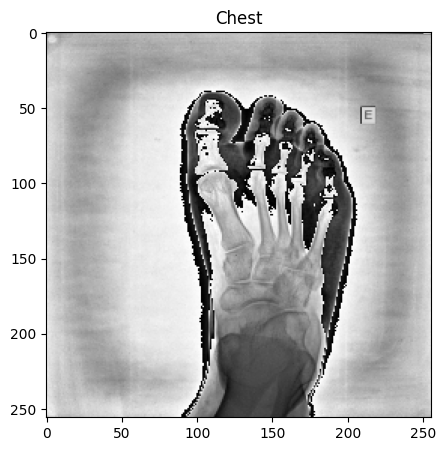

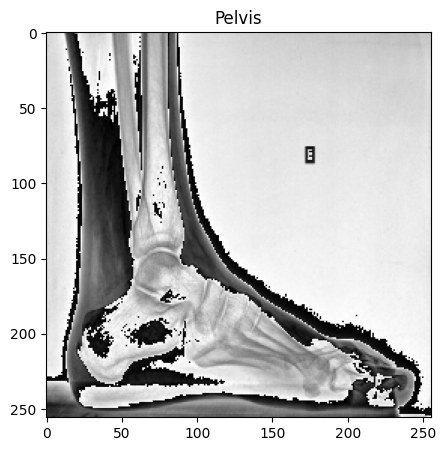

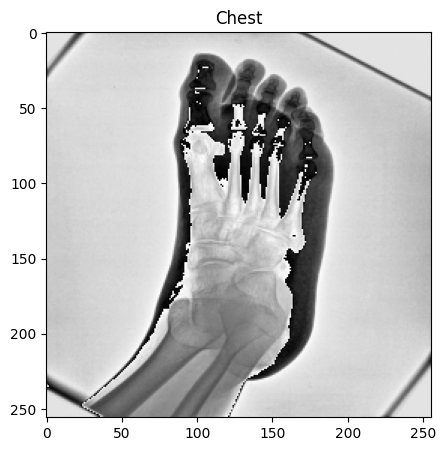

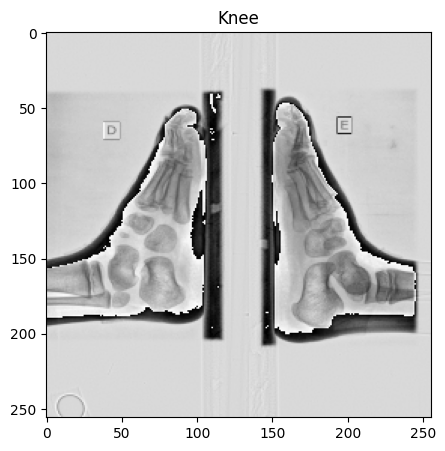

In [89]:
# 觀察測試集中前10個圖像，並附上模型預測的標籤，以評估模型表現
test_path = './testDir/Prediction'

first_ten_prediction = prediction[:10]
first_ten_images = os.listdir(test_path)[:10]
data = []

for file,prediction in zip(first_ten_images,first_ten_prediction):
    img = cv2.imread(os.path.join(test_path,file))
    data.append(img)
    plt.figure()

    label = prediction.argmax(axis=-1)
    title = train.loc[train['Label_to_numeric'] == label, 'Label'].iloc[0]
    Target = train.loc[train['Label_to_numeric'] == label, 'Target'].iloc[0]
    plt.title(title)
    plt.imshow(img)

## Generating submission file

In [ ]:
submission = pd.read_csv('/content/drive/My Drive/陽明課程/1121/機器學習/Dataset/sample_submission.csv')
submission.head()

In [ ]:
prediction = model.predict(test_generator)

In [ ]:
#Generating Target through model predictions
# 根據模型對測試資料的預測結果，生成用於提交的目標（Target）數據。
# 將模型對測試資料的預測結果轉換為對應的目標數據，並將這些數據添加到名為
# submission 的 DataFrame 中的 'Target' 欄位中，準備用於後續的提交或其他用途。

# 創建一個空列表 Target，用於存儲生成的目標數據。
Target = []
# 使用迴圈遍歷模型對於測試資料的每個預測結果。
for predict in prediction:
    # 找到每個預測結果中概率最大的類別，將其索引值存儲在 label 中。
    label = predict.argmax(axis=-1)
    # 根據預測的類別標籤（label），在訓練資料集中找到對應的目標數據，並將其添加到 Target 列表中。
    Target.append(train.loc[train['LabelCat'] == label, 'Target'].iloc[0])

# 將生成的目標數據 Target 添加到新創建的 'Target' 欄位中，這樣將測試資料的預測結果對應到了要提交的目標數據中。
submission['Target'] = Target

In [ ]:
os.getcwd()

In [ ]:
os.chdir('/content/drive/My Drive/陽明課程/1121/機器學習/Dataset')
os.listdir() #確認目錄內容

In [ ]:
# 將處理完的預測結果資料(DataFrame submission)保存為一個 CSV 檔案，方便將預測結果存儲下來以供後續使用

# 指定的路徑為 ./submission.csv，意味著檔案會保存在目前的工作目錄下，並且檔案名為 submission.csv。
submission.to_csv('./submission.csv')